In [9]:
from linares_plot import *
import scipy.io as io
import pickle
from scipy.ndimage import gaussian_filter
from scipy import misc
import os

%matplotlib inline


In [10]:
def decode_rE(rE, a_ini=0, a_fin=360, N=512):
    #Population vector for a given rE
    # return ( angle in radians, absolut angle in radians, abs angle in degrees )
    N=len(rE)
    Angles = np.linspace(a_ini, a_fin, N) 
    angles=np.radians(Angles)
    rE = np.reshape(rE, (1,N))
    R = np.sum(np.dot(rE,np.exp(1j*angles)))/np.sum(rE)
    
    angle_decoded = np.degrees(np.angle(R))
    if angle_decoded<0:
        angle_decoded = 360+angle_decoded
    
    return angle_decoded


def err_deg(a1,ref):
    ### Calculate the error ref-a1 in an efficient way in the circular space
    ### "going ccw from the reference (ref) is negative" - "going cw from the reference (ref) is positive"
    ### it uses complex numbers!
    ### Input in degrees (0-360)
    a1=np.radians(a1)
    ref=np.radians(ref)
    err = np.angle(np.exp(1j*ref)/np.exp(1j*(a1) ), deg=True) 
    err=round(err, 2)
    return err


In [32]:
path_ = 'C:\\Users\\David\\Desktop\\IDIBAPS\\brian_simulations\\r8\\'
simulations = os.listdir(path_)[:5]

In [33]:
simulations

['simulation_20391_1630941344_nitrogen.mat',
 'simulation_20391_1630941619_nitrogen.mat',
 'simulation_20391_1630942305_nitrogen.mat',
 'simulation_20391_1630942528_nitrogen.mat',
 'simulation_20391_1630943211_nitrogen.mat']

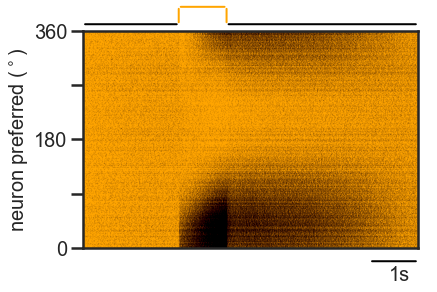

Iext: 0, Error: -24.7


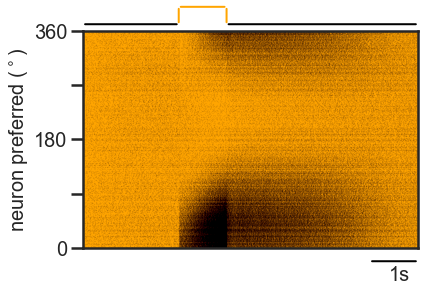

Iext: 0, Error: -42.04


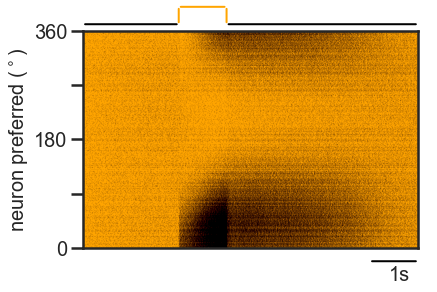

Iext: 0, Error: -22.17


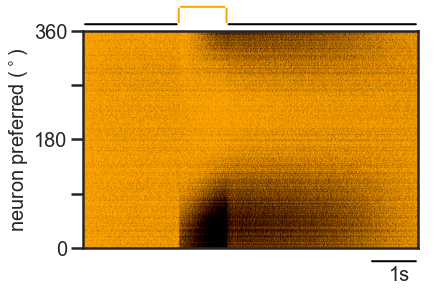

Iext: 0, Error: -9.43


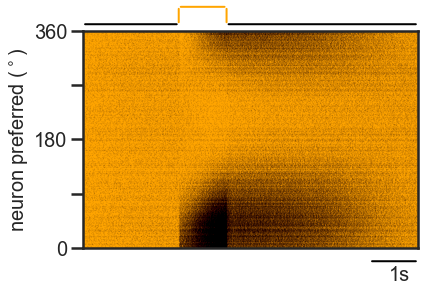

Iext: 0, Error: -21.0


In [34]:
Results_off=[]

for simulation in simulations:
    data = io.loadmat(path_ + simulation)
    spikes = data['spktm']
    rates= data['ratedelay']

    N0 = 20000
    time_s =7
    N=0.8*N0 #(el 80% son excitadoras)
    stim_on=2
    stim_off=3

    times = spikes[1] - min(spikes[1])

    fig, ax = plt.subplots()
    ax.plot(times, spikes[0], '.', markersize=0.03, color='black')
    ax.set_facecolor("orange")
    plt.xlim(0,time_s)
    plt.ylim(0,N)

    # ax = fig.add_subplot(1, 1, 1)
    inf=1.03
    sup=1.11
    ax.annotate('', xy=(0, inf), xycoords='axes fraction', xytext=(stim_on/time_s, inf), arrowprops=dict(arrowstyle="-", color='black'))
    ax.annotate('', xy=(stim_on/time_s, inf), xycoords='axes fraction', xytext=(stim_on/time_s, sup), arrowprops=dict(arrowstyle="-", color='orange'))
    ax.annotate('', xy=(stim_on/time_s, sup), xycoords='axes fraction', xytext=(stim_off/time_s, sup), arrowprops=dict(arrowstyle="-", color='orange'))
    ax.annotate('', xy=(stim_off/time_s, sup), xycoords='axes fraction', xytext=(stim_off/time_s, inf), arrowprops=dict(arrowstyle="-", color='orange'))
    ax.annotate('', xy=(stim_off/time_s, inf), xycoords='axes fraction', xytext=(1, inf), arrowprops=dict(arrowstyle="-", color='black'))

    ax.annotate('', xy=(1-1/time_s, -.06), xycoords='axes fraction', xytext=(1, -.06), arrowprops=dict(arrowstyle="-", color='black'))
    plt.text(time_s-0.6, -0.15*N, '1s', fontsize=20) ##en función de time_s y N
    plt.gca().set_xticks([])
    plt.gca().set_xticklabels([])

    plt.gca().set_yticks([0, int(N/4), int(N/2),  int(3*N/4), int(N) ])
    plt.gca().set_yticklabels(['0','','180', '', '360'], fontsize=20)
    plt.gca().set_ylabel('neuron preferred ($^\circ$)', fontsize=20);

    plt.show()
    
    
    ##############################################
    ############################################## firing rate window 100ms
    ##############################################
    
    time_s =7000 #(ms)
    rounding = 2 ##round the timing
    w=100 #(ms)


    pos_stim = 360*data['pos_stim'][0][0]
    Iext = data['IEext'][0][0]


    spikes = data['spktm']

    Matrix_spikes=np.zeros([int(0.8*N0), time_s])

    neurons_ = np.array([int(spikes[0][x]) for x in range(len(spikes[0]))])

    times_ = np.array([spikes[1][x] for x in range(len(spikes[1]))])
    times_ = times_ - min(times_)
    times_ = np.array([int(times_[x]*1000) for x in range(len(times_))])

    # dimensions = neurons, time_s
    for t, n in zip(times_, neurons_ ):
        Matrix_spikes[n,t]=1
    ##
    ####
    #### STEP 2: calculate firing of each neuron in windows of 100ms (10)
    ####
    t1s = np.arange(0, time_s ,w)
    t2s = np.arange(w, time_s+w, w)
    ##
    fr_time = []
    for N in range(np.shape(Matrix_spikes)[0]):
        neuron_fr = []
        for i in range(len(t1s)):
            neuron_fr.append(Matrix_spikes[N, t1s[i]:t2s[i]].sum()/ float(1000/w) ) 
        #
        fr_time.append(neuron_fr)
    ###
    fr_time=np.array(fr_time)
    
    
    ##############################################
    ##############################################
    ##############################################
    
    firings_wind_final=fr_time[:,-1]
    target_ = pos_stim
    decoded_position = decode_rE(firings_wind_final, N=16000)
    Error = err_deg(decoded_position, target_)
    print( 'Iext: ' + str(data['IEext'][0][0]) + ', Error: ' +str(Error))
    
    Results_off.append([Error, data['IEext'][0][0]])

In [ ]:
path_ = 'C:\\Users\\David\\Desktop\\IDIBAPS\\brian_simulations\\r8\\'
simulations = os.listdir(path_)[:5]

In [ ]:
Results_on=[]

for simulation in simulations:
    data = io.loadmat(path_ + simulation)
    spikes = data['spktm']
    rates= data['ratedelay']

    N0 = 20000
    time_s =7
    N=0.8*N0 #(el 80% son excitadoras)
    stim_on=2
    stim_off=3

    times = spikes[1] - min(spikes[1])

    fig, ax = plt.subplots()
    ax.plot(times, spikes[0], '.', markersize=0.03, color='black')
    ax.set_facecolor("orange")
    plt.xlim(0,time_s)
    plt.ylim(0,N)

    # ax = fig.add_subplot(1, 1, 1)
    inf=1.03
    sup=1.11
    ax.annotate('', xy=(0, inf), xycoords='axes fraction', xytext=(stim_on/time_s, inf), arrowprops=dict(arrowstyle="-", color='black'))
    ax.annotate('', xy=(stim_on/time_s, inf), xycoords='axes fraction', xytext=(stim_on/time_s, sup), arrowprops=dict(arrowstyle="-", color='orange'))
    ax.annotate('', xy=(stim_on/time_s, sup), xycoords='axes fraction', xytext=(stim_off/time_s, sup), arrowprops=dict(arrowstyle="-", color='orange'))
    ax.annotate('', xy=(stim_off/time_s, sup), xycoords='axes fraction', xytext=(stim_off/time_s, inf), arrowprops=dict(arrowstyle="-", color='orange'))
    ax.annotate('', xy=(stim_off/time_s, inf), xycoords='axes fraction', xytext=(1, inf), arrowprops=dict(arrowstyle="-", color='black'))

    ax.annotate('', xy=(1-1/time_s, -.06), xycoords='axes fraction', xytext=(1, -.06), arrowprops=dict(arrowstyle="-", color='black'))
    plt.text(time_s-0.6, -0.15*N, '1s', fontsize=20) ##en función de time_s y N
    plt.gca().set_xticks([])
    plt.gca().set_xticklabels([])

    plt.gca().set_yticks([0, int(N/4), int(N/2),  int(3*N/4), int(N) ])
    plt.gca().set_yticklabels(['0','','180', '', '360'], fontsize=20)
    plt.gca().set_ylabel('neuron preferred ($^\circ$)', fontsize=20);

    plt.show()
    
    
    ##############################################
    ############################################## firing rate window 100ms
    ##############################################
    
    time_s =7000 #(ms)
    rounding = 2 ##round the timing
    w=100 #(ms)


    pos_stim = 360*data['pos_stim'][0][0]
    Iext = data['IEext'][0][0]


    spikes = data['spktm']

    Matrix_spikes=np.zeros([int(0.8*N0), time_s])

    neurons_ = np.array([int(spikes[0][x]) for x in range(len(spikes[0]))])

    times_ = np.array([spikes[1][x] for x in range(len(spikes[1]))])
    times_ = times_ - min(times_)
    times_ = np.array([int(times_[x]*1000) for x in range(len(times_))])

    # dimensions = neurons, time_s
    for t, n in zip(times_, neurons_ ):
        Matrix_spikes[n,t]=1
    ##
    ####
    #### STEP 2: calculate firing of each neuron in windows of 100ms (10)
    ####
    t1s = np.arange(0, time_s ,w)
    t2s = np.arange(w, time_s+w, w)
    ##
    fr_time = []
    for N in range(np.shape(Matrix_spikes)[0]):
        neuron_fr = []
        for i in range(len(t1s)):
            neuron_fr.append(Matrix_spikes[N, t1s[i]:t2s[i]].sum()/ float(1000/w) ) 
        #
        fr_time.append(neuron_fr)
    ###
    fr_time=np.array(fr_time)
    
    
    ##############################################
    ##############################################
    ##############################################
    
    firings_wind_final=fr_time[:,-1]
    target_ = pos_stim
    decoded_position = decode_rE(firings_wind_final, N=16000)
    Error = err_deg(decoded_position, target_)
    print( 'Iext: ' + str(data['IEext'][0][0]) + ', Error: ' +str(Error))
    
    Results_off.append([Error, data['IEext'][0][0]])